# Exploring Meteorite Dataset from NASA
Link to dataset on kaggle: https://www.kaggle.com/datasets/nasa/meteorite-landings


# Table of Contents
* [Data Cleaning](#data_clean)
    * [Dealing with missing values](#missing_values)
    * [New groups for meteorite classes](#new_group)
* [EDA with visualization](#eda)
    * [Single column exploration](#single_column)
    * [The most meteorite dense area](#top_loc)
    * [Correlations between columns](#corr_columns)
        * [Correlations for column 'year'](#corr_year)
        * [Correlations for coordinates](#corr_coord)
        * [Most dense Iron meteorite area map](#iron_map)
        * [Observed falls density map](#dens_map)
* [Summary](#summary)

# 1. Data cleaning <a  class="anchor" id="data_clean"></a>

Information about dataset:
 - ***name***: the name of the meteorite (typically a location, often modified with a number, year, composition, etc)  
 - ***id***: a unique identifier for the meteorite
 - ***nametype***: one of:
    - *valid*: a typical meteorite
    - *relict*: a meteorite that has been highly degraded by weather on Earth
 - ***recclass***: the class of the meteorite; one of a large number of classes based on physical, chemical, and other characteristics (see the Wikipedia article on meteorite classification for a primer)
 - ***mass***: the mass of the meteorite, in grams
 - ***fall***: whether the meteorite was seen falling, or was discovered after its impact; one of:
    - *Fell*: the meteorite's fall was observed
    - *Found*: the meteorite's fall was not observed
 - ***year***: the year the meteorite fell, or the year it was found (depending on the value of fell)
 - ***reclat***: the latitude of the meteorite's landing
 - ***reclong***: the longitude of the meteorite's landing
 - ***GeoLocation***: a parentheses-enclose, comma-separated tuple that combines reclat and reclong

In [1]:
# Import necessary packages for EDA
import numpy as np # for linear algebra
import pandas as pd # for data processing
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import plotly.subplots as ps
import plotly.graph_objects as go
import folium as fl  # for geoviz
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.plugins import HeatMap

In [2]:
# Read csv file to pandas DataFrame
# We will call it Metorite DataFrame (mdf)
mdf = pd.read_csv('meteorite-landings.csv')
mdf.shape

(45716, 10)

In [3]:
mdf.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


## 1.1 Dealing with missing values <a class="anchor" id="missing_values"></a>

In [4]:
# Check for missing values
mdf.isnull().sum()

name              0
id                0
nametype          0
recclass          0
mass            131
fall              0
year            288
reclat         7315
reclong        7315
GeoLocation    7315
dtype: int64

In [5]:
mdf['GeoLocation'].value_counts()

GeoLocation
(0.000000, 0.000000)        6214
(-71.500000, 35.666670)     4761
(-84.000000, 168.000000)    3040
(-72.000000, 26.000000)     1505
(-79.683330, 159.750000)     657
                            ... 
(-76.303610, 157.176110)       1
(-76.286110, 157.239720)       1
(-76.318890, 157.265000)       1
(-76.287220, 157.193330)       1
(33.983330, -115.683330)       1
Name: count, Length: 17100, dtype: int64

In [6]:
# What will we do with missing coordinates?
# There is a lot of coordiantes (0, 0) so they also should be treated as missing values
# so lets assign (0, 0) to all missing values to group all of them together
mdf.loc[mdf['GeoLocation'].isnull(), 'reclat'] = 0
mdf.loc[mdf['GeoLocation'].isnull(), 'reclong'] = 0

# Fill in GeoLocation
mdf.drop('GeoLocation', axis=1)
mdf['GeoLocation'] = mdf[['reclat', 'reclong']].apply(tuple, axis = 1)

# Drop rows with missing values for year and mass column
mdf.dropna(inplace=True, axis=0)

In [7]:
mdf.isnull().sum()

name           0
id             0
nametype       0
recclass       0
mass           0
fall           0
year           0
reclat         0
reclong        0
GeoLocation    0
dtype: int64

In [8]:
# Check for duplicates
mdf.duplicated().sum()

0

In [9]:
# Check for odd values
mdf.describe()

,id,mass,year,reclat,reclong
count,45311.000000,4.531100e+04,45311.000000,45311.000000,45311.000000
mean,26805.291408,1.331468e+04,1991.947165,-33.306973,51.573082
std,16834.715854,5.767141e+05,24.798784,44.756723,77.400619
min,1.000000,0.000000e+00,601.000000,-87.366670,-165.433330
25%,12649.500000,7.120000e+00,1987.000000,-76.268580,0.000000
50%,24166.000000,3.210000e+01,1998.000000,-30.090560,35.666670
75%,40526.500000,2.000000e+02,2003.000000,0.000000,156.018740
max,57458.000000,6.000000e+07,2101.000000,81.166670,178.200000


From the table above we see, that we have wierd years in our dataset, for example 2101. Lets filter them out (dataset is from 2016), we also will be interested only in relatively recent data, this why we will filter out the years before 1800.

In [10]:
# Filter out weird years
mdf = mdf[(mdf['year'] <= 2016) & (mdf['year'] >= 1800)]

# Filter out weird locations
mdf = mdf[(mdf['reclat'] <= 180) & (mdf['reclat'] >= -180)]

In [11]:
# Lets transform mass from grams to kg
mdf['mass'] = mdf['mass']/1000

## 1.2. New groups for meteorite classes <a class="anchor" id = 'new_group'></a>

In [12]:
# How many unique meteorite classes we have in our dataset
len(mdf['recclass'].unique())

459

So we have 422 unique classes of meteorites, we can't deal with it. If explore more ([Wikipedia](https://en.wikipedia.org/wiki/Meteorite_classification)) we will find that meteorites can  be distributed into 3 larger groups:
1. Stony;
2. Stony-iron;
3. Iron.

So lets redistribute our data to this groups.
![Meteorite_class](Pictures/Meteorite_Classification_after_Weissberg_McCoy_Krot_2006_Stony_Iron.png)

In [13]:
# One can notice that names of all classes from Iron group start with I
# Lets add a new column 'recgroup' 
mdf.loc[mdf['recclass'].str.startswith('I'), 'recgroup'] = 'Iron'

# All Stony group classes start with L, C, H, R, E, K. We also can see that all martian meteorites are stony ones
stony_letters = ('L', 'C', 'H', 'R', 'E', 'K')
mdf.loc[mdf['recclass'].str.startswith(stony_letters), 'recgroup'] = 'Stony'
mdf.loc[mdf['recclass'].str.startswith('Martian'), 'recgroup'] = 'Stony'
mdf.loc[mdf['recclass'].str.startswith('Stone'), 'recgroup'] = 'Stony'

# Stony-iron group consists only of Mesosiderite and Pallasite
mdf.loc[mdf['recclass'].str.startswith('Mesosiderite'), 'recgroup'] = 'Stony-iron'
mdf.loc[mdf['recclass'].str.startswith('Pallasite'), 'recgroup'] = 'Stony-iron'

In [14]:
# How many values left ungrouped?
mdf.isnull().sum()

name             0
id               0
nametype         0
recclass         0
mass             0
fall             0
year             0
reclat           0
reclong          0
GeoLocation      0
recgroup       948
dtype: int64

In [15]:
# From what classes they are?
mdf[mdf['recgroup'].isnull()]['recclass'].unique()

array(['Acapulcoite', 'Diogenite-pm', 'Ureilite-an', 'Angrite', 'Aubrite',
       'Diogenite', 'OC', 'Ureilite', 'Winonaite', 'Achondrite-ung',
       'Brachinite', 'Ureilite-pmict', 'Acapulcoite/Lodranite',
       'Diogenite-an', 'Fusion crust', 'Aubrite-an',
       'Acapulcoite/lodranite', 'Diogenite-olivine', 'OC3',
       'Achondrite-prim'], dtype=object)

Not so many classes left ungrouped, lets figure them out.
 - **Acapulcoite**, **Angrite**, **Aubrite**, **Diogenite**, **Brachinite**, **Ureilite**, **Winonaite** are from Stony group;
 - **Fusion crust**, **OC**, **Achondrite-prim**, **Achondrite-ung** can't be grouped.


In [16]:
stony = ('Acapulcoite', 'Angrite', 'Aubrite', 'Diogenite', 'Brachinite', 'Ureilite', 'Winonaite')
mdf.loc[mdf['recclass'].str.startswith(stony), 'recgroup'] = 'Stony'


In [17]:
# How many left ungrouped in percantage
ungrouped_perc = mdf['recgroup'].isnull().sum()/mdf.shape[0]*100
ungrouped_perc

0.32919446776545447

Only around 0.3% left ungrouped, this is great!  Lets mark them as 'Unknown'.

In [18]:
unknown = ('Fusion crust', 'OC', 'Achondrite-prim', 'Achondrite-ung')
mdf.loc[mdf['recclass'].str.startswith(unknown), 'recgroup'] = 'Unknown'

In [19]:
# Check if we missed something
mdf.isnull().sum()

name           0
id             0
nametype       0
recclass       0
mass           0
fall           0
year           0
reclat         0
reclong        0
GeoLocation    0
recgroup       0
dtype: int64

# 2. EDA with visualization <a class="anchor" id="eda"></a>
After the dataset was cleaned let's visualize the data to better understand what we have.

## 2.1. Single column exploration <a class="anchor" id="single_column"></a>

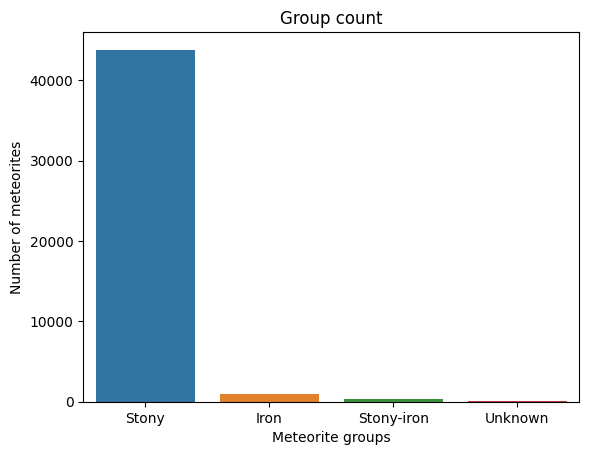

In [20]:
# How many meteorites in each group?
group_count = mdf['recgroup'].value_counts()
sns.barplot(x = group_count.index, y = group_count)
plt.xlabel("Meteorite groups")
plt.ylabel('Number of meteorites')
plt.title('Group count')
plt.show()

As one can see from this bar plot, most of the meteorites are from the Stony group, a few from the Iron group, and even fewer from the Stony-iron group.

In [21]:
# Count number of falls per year
number_of_falls = mdf[['year']].groupby('year', as_index=False)
number_of_falls = number_of_falls.value_counts()
number_of_falls

,year,count
0,1801.0,1
1,1803.0,3
2,1804.0,6
3,1805.0,3
4,1806.0,1
...,...,...
206,2009.0,1497
207,2010.0,1005
208,2011.0,713
209,2012.0,234


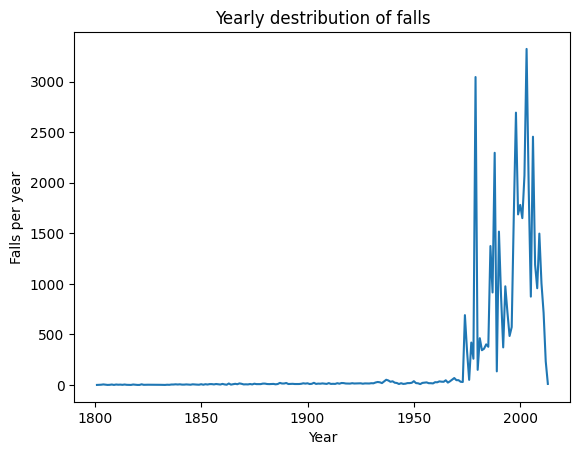

In [22]:
# Firstly, we want to see yearly destribution
sns.lineplot(data = number_of_falls, x = 'year', y = 'count')
plt.ylabel('Falls per year')
plt.xlabel('Year')
plt.title('Yearly destribution of falls')
plt.show()

We see that the number of falls increased significantly, starting around 1960. One possible explanation could be the fact that we have become better at detecting meteorites due to the development of communication technology.

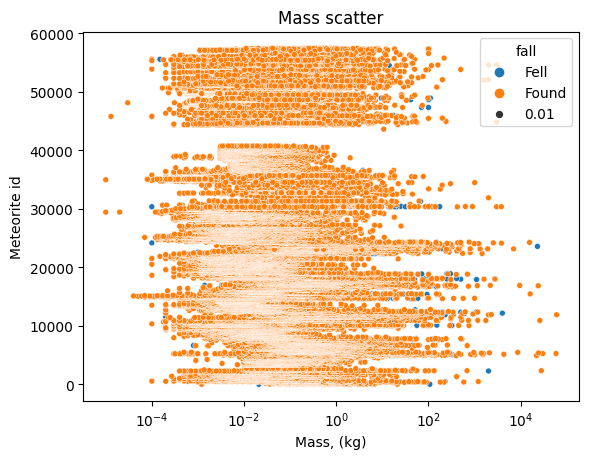

In [23]:
# Now, lets look at mass destribution
sns.scatterplot(data = mdf, x = 'mass', y = 'id', hue = 'fall', size=.01)
plt.xscale('log')
plt.ylabel('Meteorite id')
plt.xlabel('Mass, (kg)')
plt.title('Mass scatter')
plt.show()

We see that most meteorites have a mass in range from few grams to few kg. Furthermore, the dominant part was found without being seen falling.

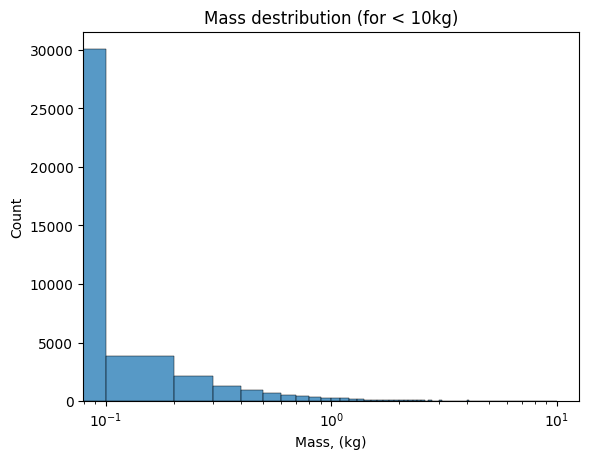

In [24]:
# Lets plot mass destribution
sns.histplot(data = mdf[mdf['mass'] <= 10], x = 'mass', bins=100)
plt.xscale('log')
plt.xlabel('Mass, (kg)')
plt.title('Mass destribution (for < 10kg)')
plt.show()

From this histogram we see that most meteorites have mass smaller than 100g. 

In [25]:
px.pie(names=['Non-observed', 'Observed'], 
       values=mdf[['fall']].value_counts(), 
       title='Meteorite fall percantage %')

As mentioned previously, the fall of over 97% of all found meteorites was not observed.

In [26]:
mdf['nametype'].value_counts()

nametype
Valid     45236
Relict       26
Name: count, dtype: int64

In [27]:
px.pie(mdf[['nametype']].value_counts(), 
       names = list(mdf['nametype'].value_counts().index), 
       values = 'count', title = 'Valid vs Relict')

Almost all meteorites were found before they can be degraded by weather conditions. This could be due to several reasons. For one, they were found not long after the fall or their landing area provided the shelter from weathering. But clear answer requires further investigation.

## 2.2 The most meteorite dense area <a class="anchor" id="top_loc"></a>

In [28]:
# Now lets see where meteorites were found on map
# Firstly, we will start with creating a terrain map
meteorite_map = fl.Map(location=[0, 0], tiles="Stamen Terrain", zoom_start=2.4)

# Marker for each meteorite, it displays Year, coordinates and meteorite class
locations = list(mdf[['reclat','reclong']].set_index('reclat').itertuples())
locations = list(mdf[mdf['GeoLocation']!=(0,0)]['GeoLocation'])
popups = [f"Date: {int(date)}, coordinates: ({lat}, {long}), Meteorite class: {mtype}" 
          for (date, lat, long, mtype) 
          in mdf[mdf['GeoLocation']!=(0,0)][['year', 'reclat', 'reclong', 'recclass']].set_index('year').itertuples()]
marker_cluster = MarkerCluster(locations=locations, popups=popups).add_to(meteorite_map)

In [29]:
# Lets add mouse position to help investigate meteorites locations
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(meteorite_map)


In [30]:
# Below demostrated screenshot
#meteorite_map

![Meteorites world map](Pictures/World-map.png)

Surprisingly enough, from the map above, we can see that Antarctica has the highest number of found meteorites (if we exclude meteorites with (0,0) coordinates), and they were discovered in three locations. If we investigate further, we will find that these locations are:
 1. Queen Alexandra Range
 2. Yamato Glacier
 3. Grove Mountains

Why is that? One [article](https://www.geographyrealm.com/why-are-there-more-meteorites-in-antarctica/) suggests:       
"Meteorites in Antarctica are more visible because the environmental conditions are favorable for the preservation and retrieval of these space rocks. The arid and cold Antarctic environment helps to preserve these rocks. ... In addition, researchers have identified meteorite hotspots known as “meteorite stranding zones”. These are areas where the local geology, the flow of the ice, and climate conditions promote the aggregation of meteorites at the surface of the blue ice."

![Antarctica meteorite map](Pictures/map-antarctic-meteorites-2022-nasa.png) 

From this picture from NASA ([link](https://earthobservatory.nasa.gov/images/149554/finding-meteorite-hotspots-in-antarctica)) we see that meteorites are mostly found in a mountain area.

In [31]:
# Lets verify our assumption about location names using our dataset
# 'name' column in the dataset contains location names, lets extract them
to_replace = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '(', ')', ' ']
for char_replace in to_replace:
    mdf['name'] = mdf['name'].str.replace(char_replace, '')
mdf['name'] = mdf['name'].str.lower()
top_names = mdf['name'].value_counts().head(20)

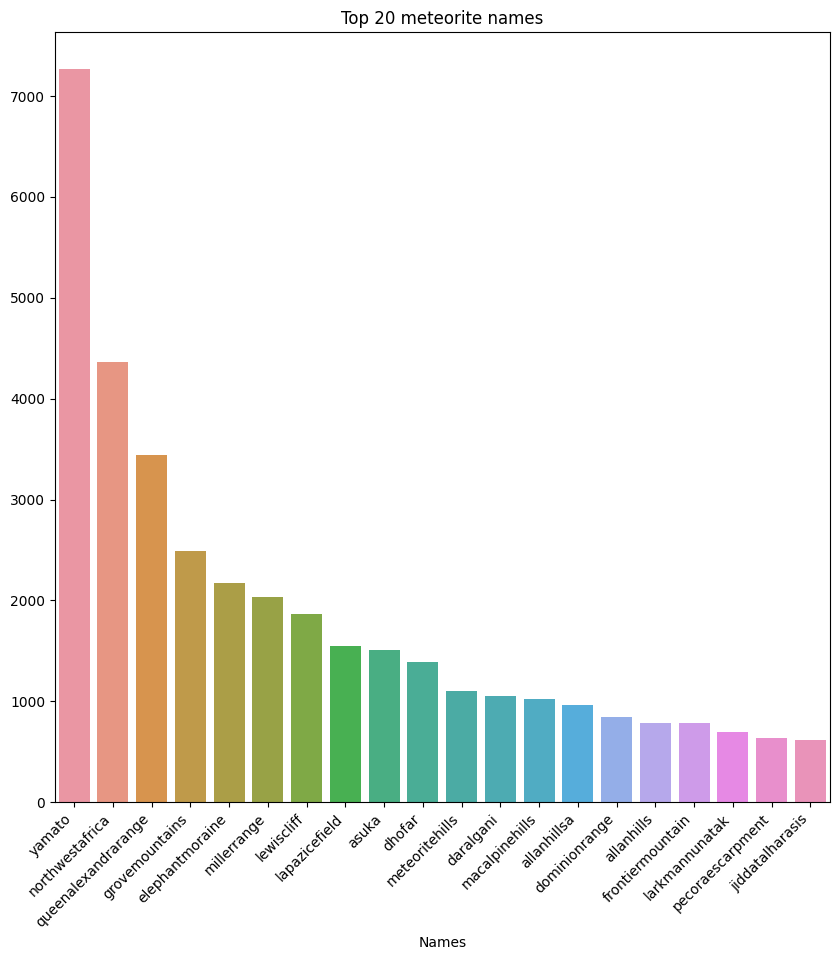

In [32]:
# Top 20 names in the dataset
plt.figure(figsize=(10,10))
ax = sns.barplot(x = top_names.index, y = top_names)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Names')
plt.ylabel('')
plt.title('Top 20 meteorite names')
plt.show()

Bar plot above confirmes our suggestion. Indeed, 3 in a top 4 locations are from Antarctica: Yamato, Queen Alexandra Range and Grove Mountains. Furthermore, fifth name from Antarctica as well, Elephant Moraine located near Ross Ice Shelf. Lets mark this four locations on the map.

In [33]:
# Antarctica map creation with markers
antarctica_map = fl.Map(location=(-73.913347, 67.28871), tiles="Stamen Terrain", zoom_start=3)

# Adds markers for top 4 meteorite locations
top_loc = {'Yamato Glacier': (-71.416667, 35.583333), 
           'Queen Alexandra Range': (-84, 168), 
           'Grove Mountains': (-72.75, 75), 
           'Elephant Moraine': (-76.283333, 157.333333)}
for loc in top_loc.keys():
    fl.Marker(location=top_loc[loc], 
              popup = loc, 
              icon = fl.Icon(color = 'red')).add_to(antarctica_map)

# Adds markers for each meteorite found in Antarctica      
locations = list(mdf[mdf['reclat'] <= -68][['reclat','reclong']].set_index('reclat').itertuples())
popups = [f"Date: {int(date)}, coordinates: ({lat}, {long}), Meteorite class: {mtype}" 
          for (date, lat, long, mtype)
          in mdf[mdf['reclat'] <= -68][['year', 'reclat', 'reclong', 'recclass']].set_index('year').itertuples()]

antarctic_markers = MarkerCluster(locations=locations, popups=popups).add_to(antarctica_map)

In [34]:
#antarctica_map

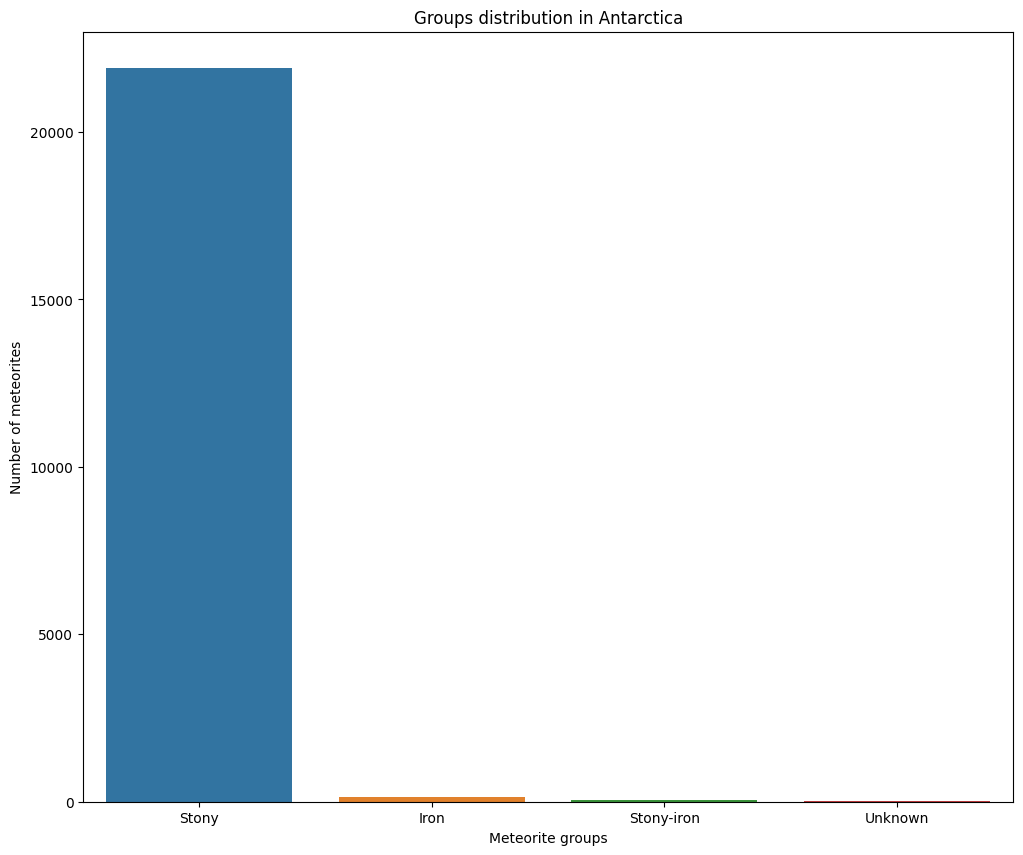

In [35]:
# Are there any difference in a group meteorites found in Antarctica? Or there is more meteorites of a one kind?
plt.figure(figsize=(12,10))
ant_met = mdf[mdf['reclat'] <= -68]['recgroup'].value_counts()
sns.barplot(x = ant_met.index, y = ant_met)
plt.xlabel('Meteorite groups')
plt.ylabel('Number of meteorites')
plt.title('Groups distribution in Antarctica')
plt.show()

It doesn't seem to be any difference in group distribution. Most of the meteorites are from the Stony group, but let's compare numbers side by side.

In [36]:
fig = ps.make_subplots(rows = 1, cols = 2, specs=[[{"type": "domain"}, {"type": "domain"}]])

fig.add_trace(go.Pie(labels = ant_met.index, values = ant_met, 
       title = 'Antarctica',
       hole = .4
       ), row = 1, col = 1)

fig.add_trace(go.Pie(labels = group_count.index, values = group_count,
       title = 'World',
       hole = .4
       ), row = 1, col = 2)
fig.update_layout(title_text = 'Group distribution: Antarctica vs World')

In this comparison, we see that there is a difference in meteorites found in Antarctica compared to the rest of the world. More than 99% are from the Stony group, whereas in the world, the total is around 97%. However, the largest difference is in the Iron group, with 0.58% in Antarctica compared to 2.23% worldwide.

## 2.3 Correlations between columns <a class="anchor" id="corr_columns"></a>

In [37]:
mdf.dtypes

name            object
id               int64
nametype        object
recclass        object
mass           float64
fall            object
year           float64
reclat         float64
reclong        float64
GeoLocation     object
recgroup        object
dtype: object

In [38]:
# Extracts numeric columns and converts fall and recgroup to numeric
mdf_num = pd.get_dummies(data = mdf, columns = ['fall', 'recgroup'])
mdf_num.drop(['name', 'id', 'nametype', 'recclass', 'GeoLocation'], axis=1, inplace = True)

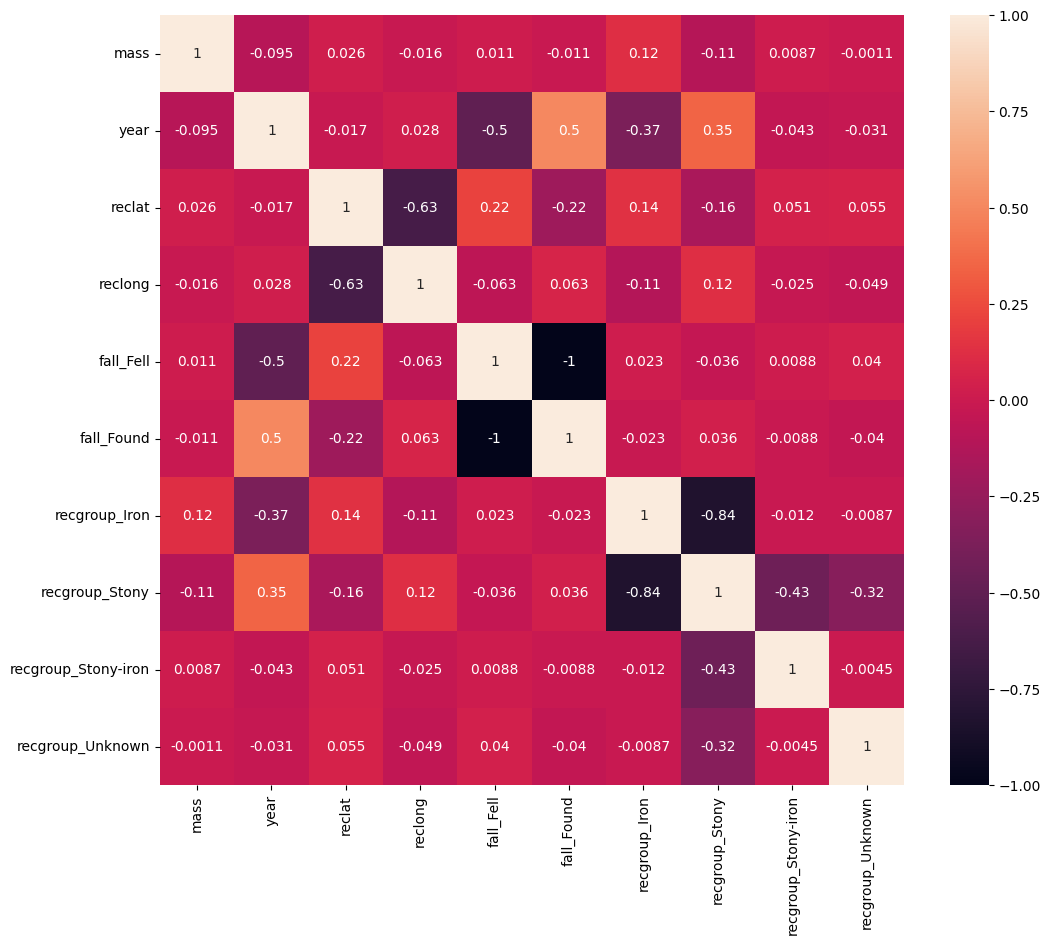

In [39]:
corr_matrix = mdf_num.corr()
fig = plt.figure(figsize = (12,10))
sns.heatmap(data = corr_matrix, annot = True)
plt.show()


Except for the obvious anti-correlation between dummies from the 'recgroup' column, we can see some notable correlations between the columns 'recgroup_Iron', 'recgroup_Stony', 'fall_Found', 'fall_Fell', and 'year', 'reclat'. So let's investigate this correlations further.

### 2.3.1 Correlations for column 'year' <a class="anchor" id="corr_year"></a>

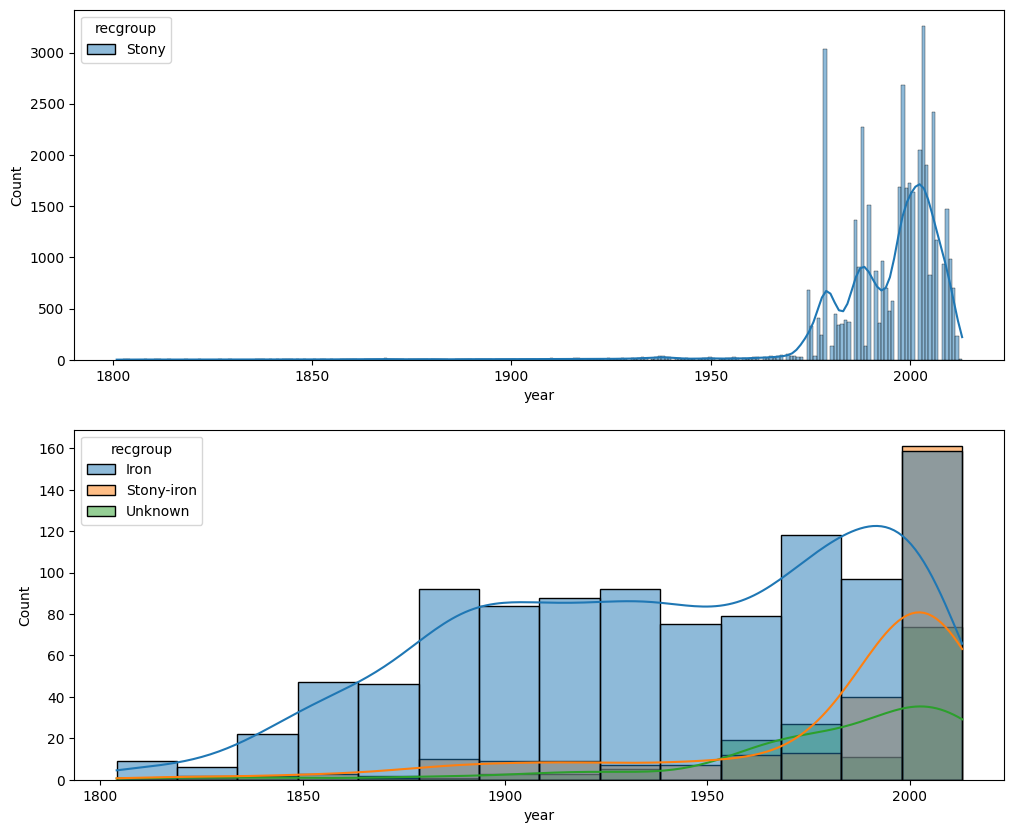

In [40]:
# We will start with correlations between 'year' and 'recgroup' columns
year_group = mdf[['year', 'recgroup']]
fig, axes = plt.subplots(2,1, figsize = (12,10))
sns.histplot(data = year_group[year_group['recgroup']=='Stony'], x = 'year', hue = 'recgroup', ax = axes[0], kde = True)
sns.histplot(data = year_group[year_group['recgroup']!='Stony'], x = 'year', hue = 'recgroup', ax = axes[1], kde = True)
plt.show()

As seen in the pictures above, the correlation between the columns 'year' and 'recgroup' is obvious. With time, the number of meteorites found increases, as does the number of meteorites in each group. Interestingly enough, the number of meteorites in the Iron group remains pretty steady.

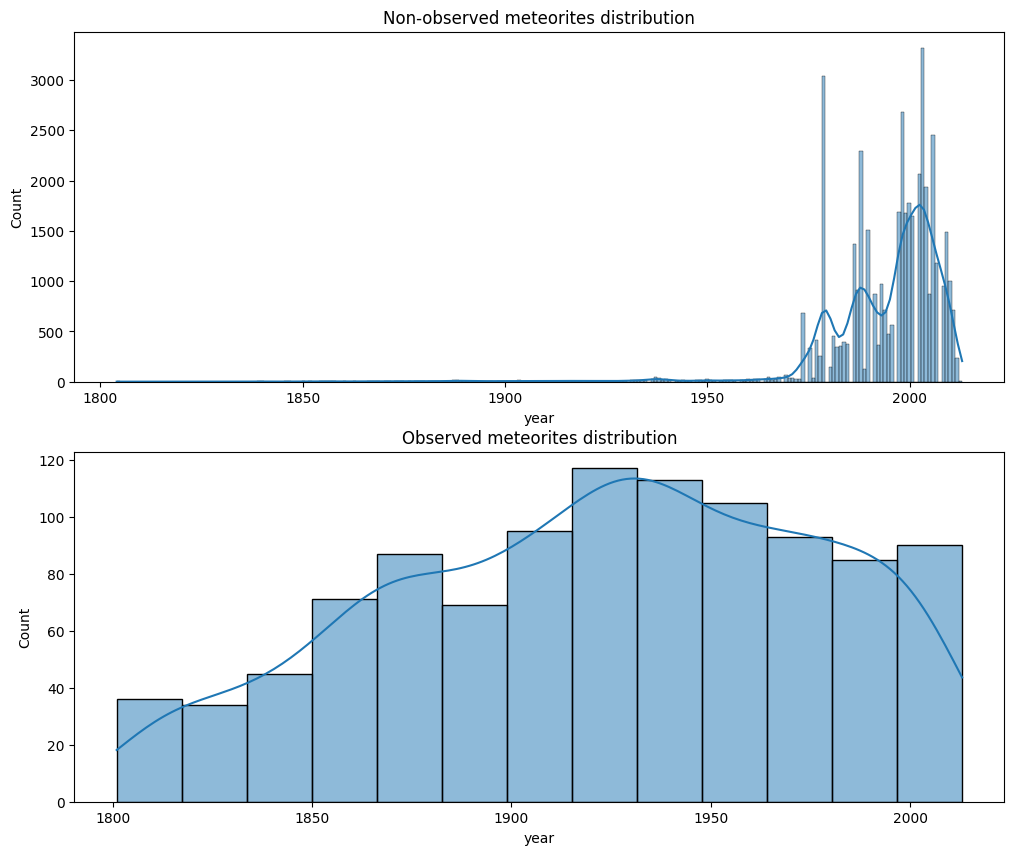

In [41]:
# Now lets look at the correlation between columns 'year' and 'fall'
fall_group = mdf[['year', 'fall']]
fig, axes = plt.subplots(2,1, figsize = (12,10))
sns.histplot(data = fall_group[fall_group['fall'] == 'Found'], x = 'year', ax = axes[0], kde = True)
sns.histplot(data = fall_group[fall_group['fall'] == 'Fell'], x = 'year', ax = axes[1], kde = True)
axes[0].set_title('Non-observed meteorites distribution')
axes[1].set_title('Observed meteorites distribution')
plt.show()

Here we see the same situation where the number of meteorites found increases with time, creating a correlation between these two columns. Another interesting observation is that number of observed meteorites doesn't increase that much with time.

This leads to a question: Do the distribution patterns of meteorite groups for observed meteorites differ from those of non-observed ones? Lets figure this out!

In [42]:
# Firstly, we separate observed and non-observed meteorites
fell_met = mdf[mdf['fall'] == 'Fell']['recgroup'].value_counts()
found_met = mdf[mdf['fall'] == 'Found']['recgroup'].value_counts()

# Secondly, lets look at numbers by plotting a pie-charts for each one
fig = ps.make_subplots(rows = 1, cols = 2, specs=[[{"type": "domain"}, {"type": "domain"}]])

fig.add_trace(go.Pie(labels = fell_met.index, values = fell_met, 
       title = 'Observed',
       hole = .4
       ), row = 1, col = 1)

fig.add_trace(go.Pie(labels = found_met.index, values = found_met,
       title = 'Non-observed',
       hole = .4
       ), row = 1, col = 2)
fig.update_layout(title_text = 'Group distribution: Observed vs Non-observed')

We observe no significant difference in the group distribution between observed and non-observed meteorites. In both cases, over 90% belong to the Stony group. However, the percentage of observed meteorites from the Iron group is higher – 4.42% compared to 2.19% for non-observed meteorites.

We have investigated correlations concerning the 'year' column. Now, let's shift our focus to the 'reclat' column.

### 2.3.2 Correlations for coordinates <a class="anchor" id="corr_coord"></a>

C:\Users\alexe\AppData\Local\Temp\ipykernel_19728\1566236037.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\alexe\AppData\Local\Temp\ipykernel_19728\1566236037.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



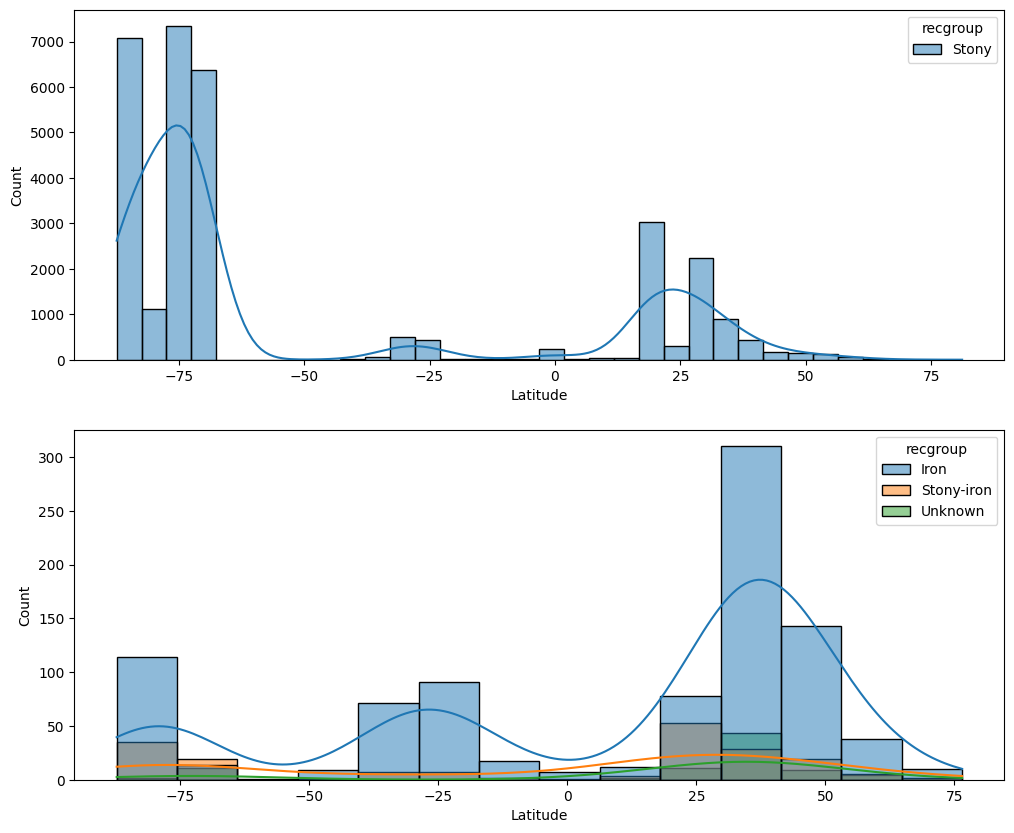

In [43]:
# Connection between 'reclat' and 'recgroup' columns
# Lets separate meteorites with missing coordinates values
# In other words lets remove rows with (0, 0) coordinates
reclat_group = mdf[(mdf[['reclat', 'reclong']].apply(tuple, axis=1) != (0.0, 0.0))][['reclat', 'recgroup']]

fig, axes = plt.subplots(2,1, figsize = (12,10))
sns.histplot(data = reclat_group[year_group['recgroup']=='Stony'], x = 'reclat', hue = 'recgroup', ax = axes[0], kde = True)
sns.histplot(data = reclat_group[year_group['recgroup']!='Stony'], x = 'reclat', hue = 'recgroup', ax = axes[1], kde = True)
axes[0].set_xlabel('Latitude')
axes[1].set_xlabel('Latitude')
plt.show()

Now, this is curious. If we look at the distributions above, we can notice that iron meteorites that landed in the northern hemisphere are shifted more to the north compared to meteorites from other groups.

C:\Users\alexe\AppData\Local\Temp\ipykernel_19728\224184531.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\alexe\AppData\Local\Temp\ipykernel_19728\224184531.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



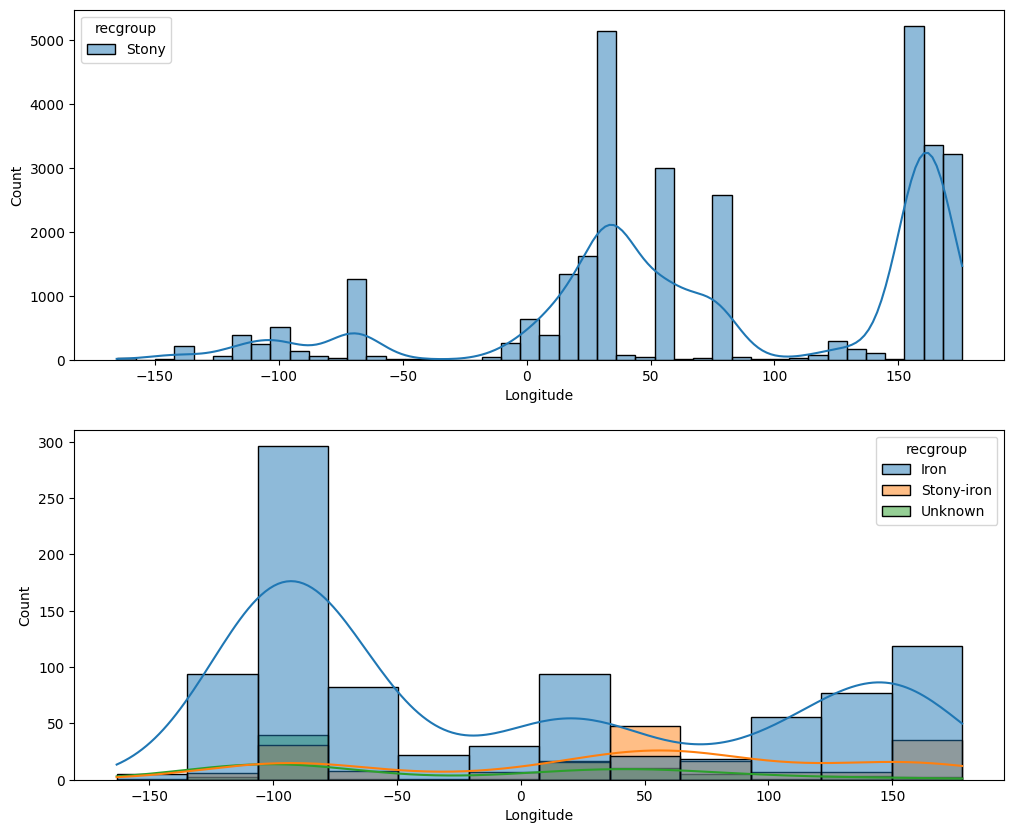

In [44]:
# Now lets look at the same figures, but for 'reclong' column
reclong_group = mdf[mdf[['reclat', 'reclong']].apply(tuple, axis=1) != (0.0, 0.0)][['reclong', 'recgroup']]

fig, axes = plt.subplots(2,1, figsize = (12,10))
sns.histplot(data = reclong_group[year_group['recgroup']=='Stony'], x = 'reclong', hue = 'recgroup', ax = axes[0], kde = True)
sns.histplot(data = reclong_group[year_group['recgroup']!='Stony'], x = 'reclong', hue = 'recgroup', ax = axes[1], kde = True)
axes[0].set_xlabel('Longitude')
axes[1].set_xlabel('Longitude')
plt.show()

Once again, we observe the same pattern. The longitudinal distribution of the Iron group differs from that of the other groups. However, this difference is not as significant as it is for the 'reclat' column. The peak around -100 is present in other groups as well, but it's not as prominent as it is for the Iron group. To explore this further, let's create a map with latitudinal coordinates ranging from 20 to 60, and longitudinal coordinates from -130 to -50.

### 2.3.3 Most dense Iron meteorite area map <a class="anchor" id="iron_map"></a>

In [45]:
# Creates map with center in (40, -90)
iron_map = fl.Map(location=(40, -90), tiles="Stamen Terrain", zoom_start=4)

iron_filtered_loc = mdf[(mdf['reclat'].between(20,60)) &        # latitudinal coordinates between 20 and 60
                     (mdf['reclong'].between(-130,-50)) &       # longitudinal coordinates  between -130 and -50
                     (mdf['recgroup'] == 'Iron')]               # filter only Iron group

locations = list(iron_filtered_loc[['reclat','reclong']].set_index('reclat').itertuples())
popups = [f"Date: {int(date)}, coordinates: ({lat}, {long}), Meteorite class: {mtype}" 
          for (date, lat, long, mtype)
          in iron_filtered_loc[['year', 'reclat', 'reclong', 'recclass']].set_index('year').itertuples()]

iron_markers = MarkerCluster(locations=locations, popups=popups).add_to(iron_map)

In [51]:
# Below is screenshot with nno interactivity
#iron_map

![North_America_map](Pictures/na-map.png)

Well, that's a surprise. It turns out the majority of Iron meteorites are found in North America. Let's examine the group distribution in this region.

In [47]:
na_dist = mdf[(mdf['reclat'].between(20,60)) &
              (mdf['reclong'].between(-130,-50))]['recgroup'].value_counts()

fig = ps.make_subplots(rows = 1, cols = 2, specs=[[{"type": "domain"}, {"type": "domain"}]])

fig.add_trace(go.Pie(labels = na_dist.index, values = na_dist, 
       title = 'North America',
       hole = .4
       ), row = 1, col = 1)

fig.add_trace(go.Pie(labels = group_count.index, values = group_count,
       title = 'World',
       hole = .4
       ), row = 1, col = 2)
fig.update_layout(title_text = 'Group distribution: North America vs World')

It gets even better. If we examine the pie chart above, we can notice that approximately 22% of all meteorites found in North America belong to the Iron group. In comparison to the global percentage, where only 2.5% are from the Iron group, this represents an almost 10-fold difference (8.78 to be exact)!

### 2.3.4 Observed falls density map <a class="anchor" id="dens_map"></a>

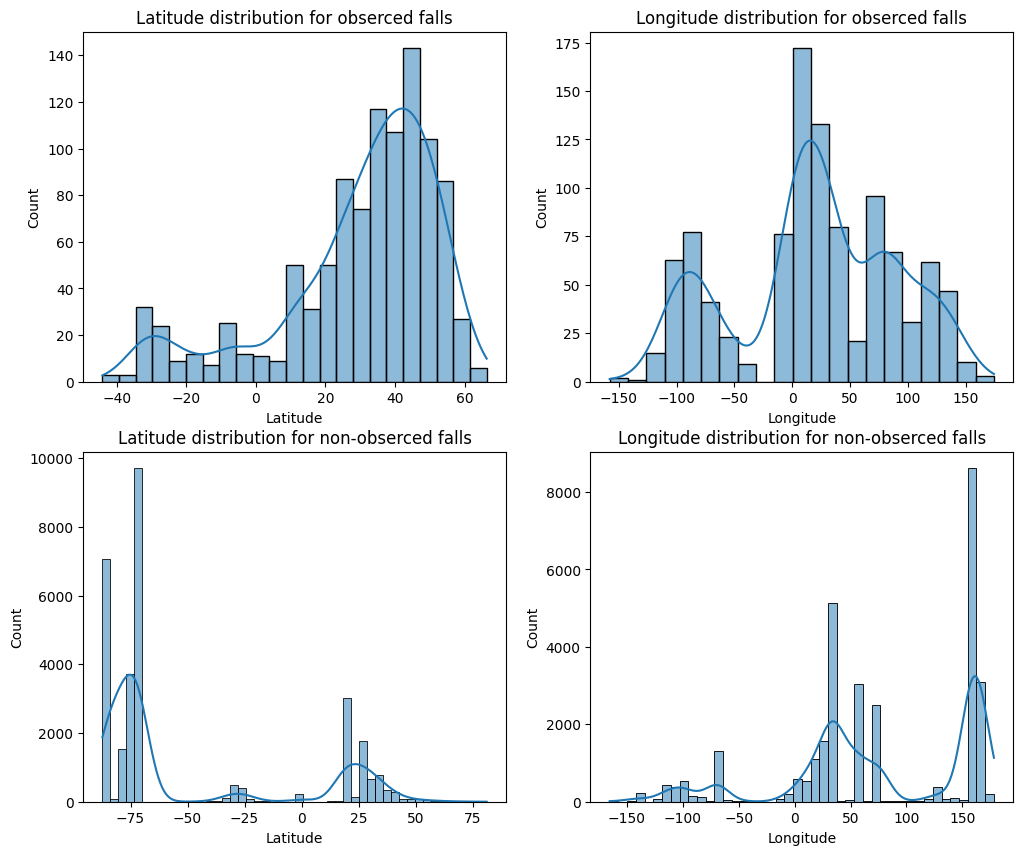

In [48]:
reclat_fell = mdf[(mdf['fall'] == 'Fell') &
                  (mdf[['reclat', 'reclong']].apply(tuple, axis=1) != (0.0, 0.0))][['reclat', 'reclong']]
reclat_found = mdf[(mdf['fall'] == 'Found') &
                  (mdf[['reclat', 'reclong']].apply(tuple, axis=1) != (0.0, 0.0))][['reclat', 'reclong']]

fig, axes = plt.subplots(2,2, figsize = (12,10))
sns.histplot( data = reclat_fell, x = 'reclat', ax = axes[0, 0], kde = True)
axes[0,0].set_xlabel('Latitude')
axes[0,0].set_title('Latitude distribution for obserced falls')
sns.histplot(data = reclat_found, x = 'reclat', ax = axes[1, 0], kde = True)
axes[1,0].set_xlabel('Latitude')
axes[1,0].set_title('Latitude distribution for non-obserced falls')
sns.histplot( data = reclat_fell, x = 'reclong', ax = axes[0, 1], kde = True)
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_title('Longitude distribution for obserced falls')
sns.histplot(data = reclat_found, x = 'reclong', ax = axes[1,1], kde = True)
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_title('Longitude distribution for non-obserced falls')

plt.show()

There is no new information for non-observed falls; we see significant peaks in latitudes that correspond with Antarctica. However, for observed falls, we observe distribution peaks that lie in the northern hemisphere. It's noteworthy that most landmass is located there.
When we examine the longitudinal distribution, we see the same trend; peaks are situated in intervals that align with the continents. We can confirm this by creating a heatmap.

In [49]:
map_dens = fl.Map(loaction = [0,0], tiles = 'Stamen Toner', zoom_start=4)
HeatMap(reclat_fell.set_index('reclat').itertuples()).add_to(map_dens)

In [54]:
# Below just screenshots
#map_dens

![west-zoom-dens](Pictures/Observed-density-heatmap-na_zoom.png)


![east-zoom-dens](Pictures/Observed-density-heatmap-na_zoom_east.png)

You can zoom in and see, that observed meteorite density increases in a more populated places. For example, you can zoom in and see it for yourself: USA West coast, Western Europe, Japan, India etc.

# 3. Summary <a class="anchor" id="summary"></a>

Firstly, let's begin with a summary of the data cleaning process. During this phase, we addressed missing values and eliminated rows with incomplete year and mass information. Additionally, we reorganized meteorites from various classes (there were over 400 classes) into four main groups: Stony, Stony-iron, Iron, and Unknown.

Secondly, during the Exploratory Data Analysis (EDA), we determined the most meteorite-dense area in the world. It turns out that Antarctica has the highest meteorite density, with the four most dense locations being Yamato, Queen Alexandra Range, Grove Mountains and Elephant Moraine. We also built an interactive map with markers for these locations, as well as for all the meteorites that landed there.

Afterward, we sought data insights by creating a correlation matrix. From this, we learned that North America has the highest concentration of Iron meteorites, accounting for 22.2% of all meteorites that landed there, compared to the global percentage of 2.5%. Furthermore, we discovered a correlation between observed fall density and population density.